In [53]:
import numpy as np
import matplotlib.pyplot as plt
import time

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import discretize
from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)
from SimPEG.electromagnetics import frequency_domain as FDEM

### Define a 3D Subsurface Model

In [54]:
conductivity_surface = 10e-3
conductivity_deep = 40e-3
conductivity_air = 1e-8

the mesh has 3240 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_22028\1435378413.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_22028\1435378413.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

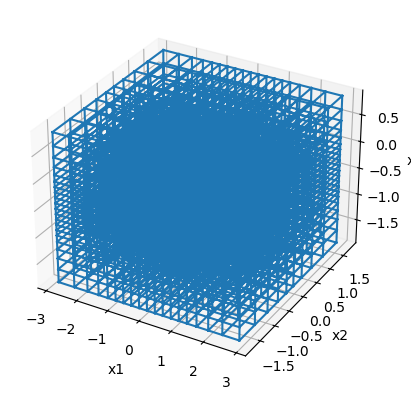

In [55]:
csx = 0.25  # cell size for the horizontal direction
csz = 0.1  # cell size for the vertical direction
pf = 1.2  # expansion factor for the padding cells

npadx = 4  # number of padding cells in the x-direction
npady = 4  # number of padding cells in the y-direction
npadz = 5  # number of padding cells in the z-direction

domain_x = np.r_[-1.25, 1.25]  # extent of uniform cells in the x-direction
domain_z = np.r_[-1, 0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(domain_x) / csx)
ncz = int(np.diff(domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0].sum() / 2.0, -mesh.h[1].sum() / 2.0, -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

In [56]:
mesh

TensorMesh: 3,240 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     18         -2.86          2.86      0.25      0.52    1.20
   y      9         -1.74          1.74      0.25      0.52    1.20
   z     20         -1.89          0.89      0.10      0.25    1.20

### 2D Inversion Mesh

<Axes: xlabel='x1', ylabel='x2'>

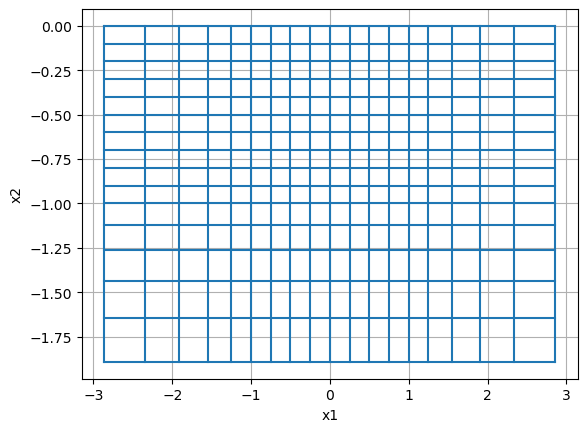

In [57]:
inversion_mesh = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh.x0 = [-inversion_mesh.h[0].sum() / 2.0, -inversion_mesh.h[1].sum()]
inversion_mesh.plot_grid()

In [58]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, conductivity_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )
)

### Define Model

Text(0.5, 1.0, 'true model')

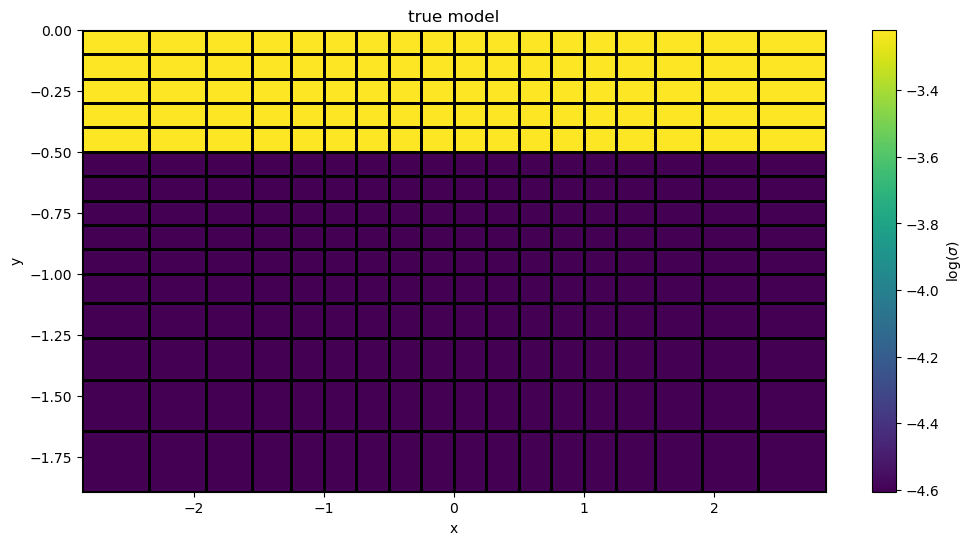

In [59]:
m_true = np.log(conductivity_deep) * np.ones(inversion_mesh.nC)
m_true[inversion_mesh.gridCC[:, 1] < -0.5*np.ones_like(inversion_mesh.gridCC[:, 0])] = np.log(conductivity_surface)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
cb = plt.colorbar(inversion_mesh.plot_image(m_true, ax=ax, grid=True)[0], ax=ax)
cb.set_label(r"$\log(\sigma)$")
ax.set_title("true model")
# ax.set_xlim([0, 10.0e3])
# ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, color='k', which="both")

### Define Survey

In [60]:
frequencies = [1000, 10000, 100000]
coil_separations = np.arange(0.05, 0.7, 0.05)
src_locations = np.arange(-1.2, 1.2, 0.2)
src_z = 0.10  # src is 0.25m above the surface
orientation = "z"  # z-oriented dipole for horizontal co-planar loops

# reciever offset in 3D space
rx_offsets = np.vstack([np.r_[sep, 0.0, 0.0] for sep in coil_separations])

# create our source list - one source per location
source_list = []
for x in src_locations:
    for freq in frequencies:
        src_loc = np.r_[x, 0.0, src_z]
        rx_locs = src_loc - rx_offsets

        rx_real = FDEM.Rx.PointMagneticFluxDensitySecondary(
            locations=rx_locs, orientation=orientation, component="real"
        )
        rx_imag = FDEM.Rx.PointMagneticFluxDensitySecondary(
            locations=rx_locs, orientation=orientation, component="imag"
        )

        src = FDEM.Src.MagDipole(
            receiver_list=[rx_real, rx_imag],
            location=src_loc,
            orientation="x",
            frequency=freq,
        )

        source_list.append(src)

# create the survey and problem objects for running the forward simulation
survey = FDEM.Survey(source_list)
prob = FDEM.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver
)

In [61]:
data = prob.make_synthetic_data(
    m_true, relative_error=0.05, noise_floor=1e-11, add_noise=False
)

dclean = data.dclean

# def plot_data(data, ax=None, color="C0", label=""):
#     if ax is None:
#         fig, ax = plt.subplots(len(coil_separations), 1, figsize=(5, 15))

#     # data is [re, im, re, im, ...]
#     data_real = data[0::2]
#     data_imag = data[1::2]

#     for i, offset in enumerate(coil_separations):
#         ax[i].plot(
#             src_locations,
#             data_real[i :: len(coil_separations)],
#             color=color,
#             label="{} real".format(label),
#         )
#         ax[i].plot(
#             src_locations,
#             data_imag[i :: len(coil_separations)],
#             "--",
#             color=color,
#             label="{} imag".format(label),
#         )

#         ax[i].set_title("offset = {:1.2f}m".format(offset))
#         ax[i].legend()
#         ax[i].grid(which="both")
#         ax[i].set_ylim(np.r_[data.min(), data.max()] + 1e-11 * np.r_[-1, 1])

#         ax[i].set_xlabel("source location x (m)")
#         ax[i].set_ylabel("Secondary B-Field (T)")

#     plt.tight_layout()
#     return ax


# ax = plot_data(dclean)

### Setup the inversion

In [62]:
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data)
reg = regularization.WeightedLeastSquares(inversion_mesh)
opt = optimization.InexactGaussNewton(maxIterCG=10, remember="xc")
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

betaest = directives.BetaEstimate_ByEig(beta0_ratio=0.05, n_pw_iter=1, seed=1)
target = directives.TargetMisfit()

directiveList = [betaest, target]
inv = inversion.BaseInversion(invProb, directiveList=directiveList)

print("The target misfit is {:1.2f}".format(target.target))

The target misfit is 468.00


In [63]:
m0 = np.log(conductivity_deep) * np.ones(inversion_mesh.nC)

t = time.time()
mrec = inv.run(m0)
print("\n Inversion Complete. Elapsed Time = {:1.2f} s".format(time.time() - t))

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.20e+03  1.17e+02  0.00e+00  1.17e+02    6.65e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <

In [64]:
# fig, ax = plt.subplots(len(coil_separations), 1, figsize=(5, 15))
# plot_data(dclean, ax=ax, color="C0", label="true")
# plot_data(invProb.dpred, ax=ax, color="C1", label="predicted")

### Result

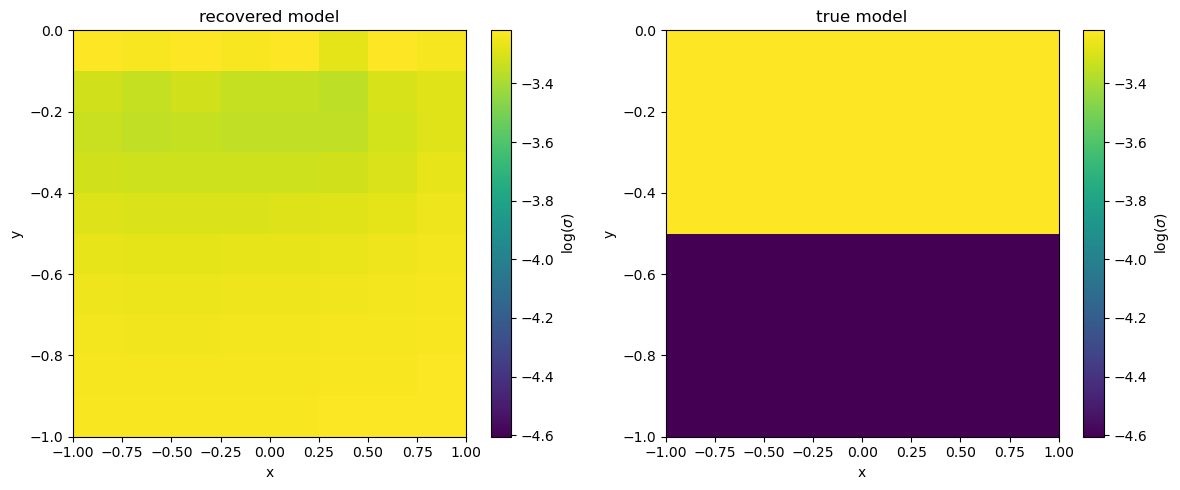

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# put both plots on the same colorbar
clim = np.r_[np.log(conductivity_surface), np.log(conductivity_deep)]

# recovered model
cb = plt.colorbar(
    inversion_mesh.plot_image(mrec, ax=ax[0], clim=clim)[0],
    ax=ax[0],
)
ax[0].set_title("recovered model")
cb.set_label(r"$\log(\sigma)$")

# true model
cb = plt.colorbar(
    inversion_mesh.plot_image(m_true, ax=ax[1], clim=clim)[0],
    ax=ax[1],
)
ax[1].set_title("true model")
cb.set_label(r"$\log(\sigma)$")

# # uncomment to plot the true interface
# x = np.linspace(-10, 10, 50)
# [a.plot(x, interface(x), 'k') for a in ax]

[a.set_xlim([-1, 1]) for a in ax]
[a.set_ylim([-1, 0]) for a in ax]

plt.tight_layout()
plt.show()